In [ ]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [ ]:

import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import pickle
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, roc_auc_score, f1_score, accuracy_score, multilabel_confusion_matrix, ConfusionMatrixDisplay, confusion_matrix
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from src.data_processor.phase_3.prob2.v1 import  Phase3Prob2FeatureProcessor
import numpy as np
import gc
from collections import Counter

In [3]:
df = pd.read_parquet("F:/Data/MLOPS_2023/data_phase-3/phase-3/prob-2/raw_train.parquet")

In [4]:
print(df.shape)
df.drop_duplicates(inplace=True)
df.reset_index(inplace=True, drop=True)
df.shape

(92762, 42)


(65191, 42)

In [11]:
df2 = pd.read_csv("F:/Data/MLOPS_2023/UNSW_NB15_training-set.csv")
df3 = pd.read_csv("F:/Data/MLOPS_2023/UNSW_NB15_testing-set.csv")
df2 = pd.concat([df2, df3])
del df3
gc.collect()

0

In [12]:
df2['label'] = df2['attack_cat']
mapping = {
            "Normal": "Normal",
            "DoS":"Denial of Service",
            "Reconnaissance":"Information Gathering",
            "Analysis": "Information Gathering",
            "Exploits": "Exploits",
            "Shellcode": "Malware",
            "Worms": "Malware",
            "Backdoor":"Malware",
            "Generic": "Other",
            "Fuzzers": "Other"
            }
df2["label"] = df2["label"].map(mapping)
print(df2["label"].value_counts(dropna=False))
print(df2.shape)
df2.drop(columns=['id','rate','attack_cat'],inplace=True)
df2.drop_duplicates(inplace=True)
print(df2["label"].value_counts(dropna=False))
df2.shape

Normal                   93000
Other                    83117
Exploits                 44525
Information Gathering    16664
Denial of Service        16353
Malware                   4014
Name: label, dtype: int64
(257673, 45)
Normal                   85722
Other                    28281
Exploits                 27434
Information Gathering    10686
Denial of Service         5500
Malware                   3507
Name: label, dtype: int64


(161130, 42)

In [14]:
feat_to_name = {k:v for k,v in zip(df.columns,df2.columns)}
name_to_feat = {k:v for k,v in zip(df2.columns, df.columns)}
df2.columns = [name_to_feat[c] for c in df2.columns]
df2.columns

Index(['feature1', 'feature2', 'feature3', 'feature4', 'feature5', 'feature6',
       'feature7', 'feature8', 'feature9', 'feature10', 'feature11',
       'feature12', 'feature13', 'feature14', 'feature15', 'feature16',
       'feature17', 'feature18', 'feature19', 'feature20', 'feature21',
       'feature22', 'feature23', 'feature24', 'feature25', 'feature26',
       'feature27', 'feature28', 'feature29', 'feature30', 'feature31',
       'feature32', 'feature33', 'feature34', 'feature35', 'feature36',
       'feature37', 'feature38', 'feature39', 'feature40', 'feature41',
       'label'],
      dtype='object')

In [15]:
a = df.merge(df2, how='left', on=list(df2.columns[:-1]))

In [16]:
# df2.drop_duplicates(df2.columns[:-1],keep=False, inplace=True)
# print(df2["label"].value_counts(dropna=False))
# df2.shape

In [24]:
df.groupby(list(df.columns[:-1]))

In [9]:
df3 = pd.concat([df, df2])

In [11]:
df3.drop_duplicates(inplace=True)
print(df3.shape)

(168446, 42)


In [12]:
df3['feature2'].nunique()

133

In [13]:
HyperParameters={'objective': 'multiclass',
                 'n_estimators':300,
                 'learning_rate':0.1,
                 'max_depth':32,
                 'colsample_bytree':0.5,
                 'subsample':0.8,
                 'reg_alpha':1.2,
                 'reg_lambda':10,
                 'random_state':42}
            
hyper_parameters = HyperParameters.copy()

In [14]:
TARGET = 'label'
processor = Phase3Prob2FeatureProcessor()
new_df = processor.transform(df)
kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
FEATURES = processor.data_features['features']
categorical = processor.data_features['categorical_features']
# hyper_parameters['objective'] = 'multiclass'
models = []
scores = []
oofs = np.empty(df.shape[0], dtype='object')
for i, (train_idx, valid_idx) in enumerate(kfold.split(new_df, df[TARGET])):
    # Xy_train = new_df.iloc[train_idx]
    # Xy_train['label'] = df.iloc[train_idx][TARGET]
    # Xy_train_NORMAL = Xy_train[Xy_train.label.apply(lambda x: x == 'Malware')]
    # Xy_train_NORMAL_sample = Xy_train_NORMAL.sample(frac=1, random_state=42)
    # # print(Xy_train_NORMAL_sample['label'].value_counts())
    # Xy_train_OTHER = Xy_train[Xy_train.label.apply(lambda x: x != 'Malware')]
    # Xy_train_sample = pd.concat([Xy_train_OTHER,Xy_train_NORMAL_sample])
    # Xy_train_sample = Xy_train_sample.sample(frac=1,random_state=123)
    # print(Xy_train_sample['label'].value_counts())

    X_train = new_df.iloc[train_idx]
    y_train = df.iloc[train_idx][TARGET]
    X_valid = new_df.iloc[valid_idx]
    y_valid = df.iloc[valid_idx][TARGET]


    print(X_train.shape, X_valid.shape)
    print(y_train.shape, y_valid.shape)
    model = LGBMClassifier(**hyper_parameters)
    model.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_valid, y_valid)],
              eval_metric=["logloss"],
              categorical_feature=categorical,
              early_stopping_rounds=50,
              verbose=50)
    # model = CatBoostClassifier(iterations=100, learning_rate=0.05, max_depth=7, subsample=0.8, random_state=42,eval_metric='AUC',class_weights={1:1.5,0:1})
    # model.fit(X_train, y_train,
    #           cat_features=categorical,
    #           eval_set=[(X_train, y_train), (X_valid, y_valid)])
    models.append(model)
    y_pred = model.predict(X_valid)
    oofs[valid_idx] = y_pred

    print(f"fold {i} : {accuracy_score(y_valid, y_pred)}")
    print(classification_report(y_valid, y_pred))
    scores.append(accuracy_score(y_valid, y_pred))

print(np.mean(scores), np.std(scores))
print(classification_report(df[TARGET], oofs))
print(accuracy_score(df[TARGET], oofs))

(52152, 41) (13039, 41)
(52152,) (13039,)
[50]	training's multi_logloss: 0.379524	valid_1's multi_logloss: 0.412456
[100]	training's multi_logloss: 0.339806	valid_1's multi_logloss: 0.401632
[150]	training's multi_logloss: 0.314727	valid_1's multi_logloss: 0.400694
fold 0 : 0.8179308229158678
                       precision    recall  f1-score   support

    Denial of Service       0.57      0.54      0.55      2063
             Exploits       0.72      0.80      0.76      2314
Information Gathering       0.81      0.67      0.73       901
              Malware       0.64      0.30      0.41       264
               Normal       0.91      0.94      0.92      6365
                Other       0.99      0.93      0.96      1132

             accuracy                           0.82     13039
            macro avg       0.77      0.70      0.72     13039
         weighted avg       0.82      0.82      0.81     13039

(52153, 41) (13038, 41)
(52153,) (13038,)
[50]	training's multi_logloss: 

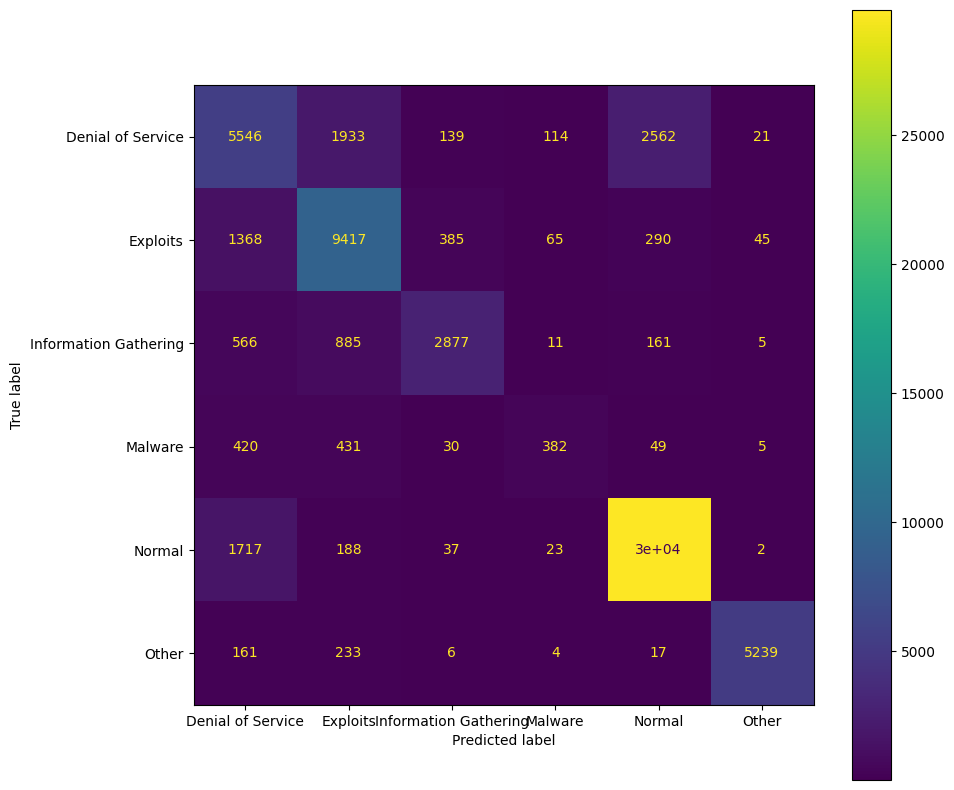

In [17]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(df[TARGET],oofs,labels=models[0].classes_), display_labels=models[0].classes_)
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(10,10))
disp.plot(ax=ax)

In [16]:
gmodel = LGBMClassifier(**models[0].get_params())
gmodel.fit(new_df[FEATURES], df[TARGET],
           eval_set=[(new_df[FEATURES],df[TARGET])],
           eval_metric=["logloss"],
           categorical_feature=categorical,
           verbose=50)

with open(f'../checkpoints/phase-3/prob-2/v1.pkl','wb') as file:
    pickle.dump(gmodel, file)

[50]	valid_0's multi_logloss: 0.38065
[100]	valid_0's multi_logloss: 0.343761
[150]	valid_0's multi_logloss: 0.322023
[200]	valid_0's multi_logloss: 0.304625
[250]	valid_0's multi_logloss: 0.29016
[300]	valid_0's multi_logloss: 0.277982


In [27]:
files = os.listdir("F:/Data/MLOPS_2023/data_phase-3/test-stage-1/prob-2/")

In [28]:
dfs = []
for file in files:
    x = pd.read_csv("F:/Data/MLOPS_2023/data_phase-3/test-stage-1/prob-2/"+file)
    dfs.append(x)

In [29]:
dfs = pd.concat(dfs)

In [30]:
print(dfs.shape)
dfs.drop_duplicates(inplace=True)
print(dfs.shape)

(112312, 41)
(11048, 41)


In [32]:
dfs = dfs[df.columns[:-1]]

In [33]:
dfs.drop_duplicates().shape

(11011, 41)

In [48]:
aaa = dfs.merge(df3, how='left', on = ['feature1', 'feature2', 'feature3', 'feature4', 'feature5', 'feature6',
       'feature7', 'feature8', 'feature9', 'feature10', 'feature11',
       'feature12', 'feature13', 'feature14', 'feature15', 'feature16',
       'feature17', 'feature18', 'feature19', 'feature20', 'feature21',
       'feature22', 'feature23', 'feature24', 'feature25', 'feature26',
       'feature27', 'feature28', 'feature29', 'feature30', 'feature31',
       'feature32', 'feature33', 'feature34', 'feature35', 'feature36',
       'feature37', 'feature38', 'feature39', 'feature40', 'feature41'])

In [49]:
aaa['label'].value_counts(dropna=False)

Normal                   4035
Other                    3734
Exploits                 2250
Information Gathering    1483
NaN                      1391
Denial of Service        1301
Malware                   989
Name: label, dtype: int64

In [50]:
feat = processor.transform(aaa)

In [51]:
aaa['predict'] = gmodel.predict(feat)

In [52]:
aaa[aaa['label'] != aaa['predict']]['label'].value_counts(dropna=False)

NaN                      1391
Denial of Service        1129
Other                    1110
Information Gathering     956
Malware                   825
Exploits                  654
Normal                    149
Name: label, dtype: int64

In [53]:
bbb = aaa.dropna(subset=['label'])

In [54]:
print(accuracy_score(bbb['label'],bbb['predict']))

0.650304524361949


In [55]:
bbb

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,...,feature34,feature35,feature36,feature37,feature38,feature39,feature40,feature41,label,predict
0,0.622748,tcp,-,FIN,10.0,8.0,564.0,354.0,254.0,252.0,...,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,Information Gathering,Information Gathering
1,0.419288,tcp,smtp,FIN,52.0,42.0,37372.0,3380.0,31.0,29.0,...,1.0,1.0,0.0,0.0,0.0,2.0,1.0,0.0,Normal,Normal
2,23.268108,sctp,-,CON,250.0,24.0,248562.0,1652.0,254.0,60.0,...,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,Denial of Service,Other
3,23.268108,sctp,-,CON,250.0,24.0,248562.0,1652.0,254.0,60.0,...,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,Exploits,Other
4,23.268108,sctp,-,CON,250.0,24.0,248562.0,1652.0,254.0,60.0,...,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,Information Gathering,Other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15173,6.036488,tcp,http,FIN,330.0,746.0,17642.0,1087890.0,31.0,29.0,...,1.0,1.0,0.0,0.0,1.0,3.0,4.0,0.0,Normal,Normal
15174,0.466848,tcp,-,FIN,10.0,6.0,612.0,268.0,254.0,252.0,...,1.0,4.0,0.0,0.0,0.0,2.0,6.0,0.0,Normal,Normal
15177,0.856529,tcp,ftp,FIN,52.0,54.0,2934.0,3742.0,31.0,29.0,...,1.0,4.0,1.0,1.0,0.0,13.0,1.0,0.0,Normal,Normal
15180,0.019142,tcp,-,FIN,16.0,18.0,1540.0,1644.0,31.0,29.0,...,1.0,6.0,0.0,0.0,0.0,11.0,6.0,0.0,Normal,Normal
